## All you need is love… And a pet!

<img src="img/dataset-cover.jpg" width="920">

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
from sklearn.linear_model import LogisticRegression
import seaborn as sn
import random
%matplotlib inline

data_folder = './data/'

### A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). 
- Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. 
- Standardize the values of each feature in the data to have mean 0 and variance 1.

The use of external libraries is not permitted in part A, except for numpy and pandas. 
You can drop entries with missing values.

In [27]:
columns = ['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake', \
          'age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome', 'age_upon_outcome_(years)', \
          'outcome_type']
original_data = pd.read_csv(data_folder+'aac_intakes_outcomes.csv', usecols=columns)

In [28]:
categorical_features = [
 'animal_type',
 'intake_condition',
 'intake_type',
 'sex_upon_intake',
 'sex_upon_outcome',
#  'outcome_type'
]
data_dummies = pd.get_dummies(original_data, columns=categorical_features, drop_first=True)
data_dummies.sample(5)

,outcome_type,age_upon_outcome_(years),age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,animal_type_Cat,animal_type_Dog,animal_type_Other,intake_condition_Feral,...,intake_type_Stray,intake_type_Wildlife,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
37850,Transfer,0.164384,0.164384,2015,1.0,1.015972,False,True,False,False,...,False,False,True,False,False,False,True,False,False,False
34999,Return to Owner,2.000000,2.000000,2015,1.0,9.868750,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13530,Adoption,1.000000,1.000000,2014,1.0,8.257639,False,True,False,False,...,True,False,True,False,False,False,False,True,False,False
46973,Adoption,7.000000,7.000000,2016,1.0,9.054167,False,True,False,False,...,True,False,True,False,False,False,False,True,False,False
33973,Euthanasia,2.000000,2.000000,2015,1.0,0.745833,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False


In [30]:
data_dummies["adopted"] = data_dummies["outcome_type"] == "Adoption"
data_dummies["adopted"].head()

0    False
1    False
2    False
3    False
4    False
Name: adopted, dtype: bool

In [29]:
print(len(data_dummies))
data_dummies.dropna()
print(len(data_dummies))

79672
79672


In [19]:
to_std_columns = ["intake_year", "intake_number", "age_upon_intake_(years)", "time_in_shelter_days", "age_upon_outcome_(years)"]

data_dummies[to_std_columns] = (data_dummies[to_std_columns] - data_dummies[to_std_columns].mean(axis=0)) / data_dummies[to_std_columns].std(axis=0)

In [86]:
def train_test_spli(data, X_remove, y_col, proportion: float = 0.8, seed: int = 42):
    random.seed(seed)
    N = len(data)
    indices = list(range(N))
    random.shuffle(indices)
    split = int(N*proportion)

    X = data.drop(columns=X_remove)
    y = data[y_col]
    X_train, y_train = X.iloc[:split], y.iloc[:split]
    X_test , y_test  = X.iloc[split:], y.iloc[split:]
    return X_train, y_train, X_test , y_test

X_train, y_train, X_test , y_test = train_test_spli(data_dummies, X_remove=['adopted', 'outcome_type'], y_col="adopted")

### B) Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. 
- For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. 

In [87]:
model = LogisticRegression(solver="lbfgs")
model.fit(X_train.values, y_train)

c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [88]:
pred = model.predict(X_test.values)
pred

array([False,  True, False, ..., False, False, False])

In [89]:
distribution = model.predict_proba(X_test.values)
distribution

array([[0.63856026, 0.36143974],
       [0.25337377, 0.74662623],
       [0.99899143, 0.00100857],
       ...,
       [0.99887363, 0.00112637],
       [0.94115538, 0.05884462],
       [0.88642884, 0.11357116]])

In [90]:
def confusion_matrix(y_pred, y_true, verbose: bool = True, plot: bool = False):
    tp = np.sum((y_pred == 1) & (y_true == 1))  # True Positives
    tn = np.sum((y_pred == 0) & (y_true == 0))  # True Negatives
    fp = np.sum((y_pred == 1) & (y_true == 0))  # False Positives
    fn = np.sum((y_pred == 0) & (y_true == 1))  # False Negatives

    eps = 1e-6
    precision = (tp + eps) / (tp + fp + eps)
    recall = (tp + eps) / (tp + fn + eps)
    f_score = 2 * (precision * recall + eps) / (precision + recall + eps)
    
    if verbose:
        print(f"{tp = :6d} | {fp = :6d}")
        print(f"----------- |  -----------")
        print(f"{fn = :6d} | {tn = :6d}")
        print(f"{precision = :.4}")
        print(f"{recall = :.4}")
        print(f"{f_score = :.4}")
        
    if plot:
        confusion_matrix = np.array([[tp, fn],  
                                    [fp, tn]]) 

        confusion_matrix = pd.DataFrame(confusion_matrix, 
                                    index=["Actual Positive", "Actual Negative"], 
                                    columns=["Predicted Positive", "Predicted Negative"])

        plt.figure(figsize=(8, 6))
        sn.heatmap(confusion_matrix, annot=True, fmt="d", cmap='YlGnBu', cbar=False)
        plt.title("Confusion Matrix")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.tight_layout()
        plt.show()
    
    return f_score, precision, recall


tp =   5864 | fp =   1087
----------- |  -----------
fn =   1487 | tn =   7497
precision = 0.8436
recall = 0.7977
f_score = 0.82


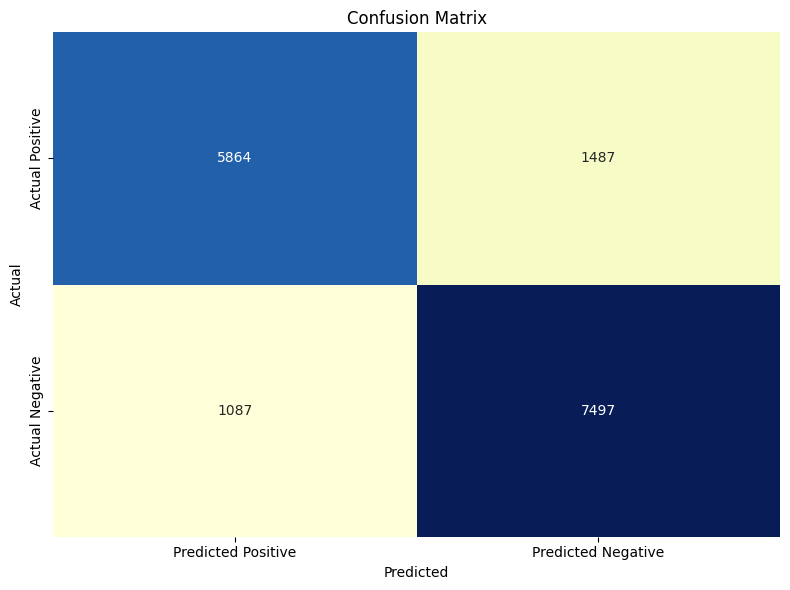

(0.8200258902414194, 0.843619623098314, 0.7977145966810346)

In [91]:
confusion_matrix(pred, y_test, plot=True)

### C) Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold.

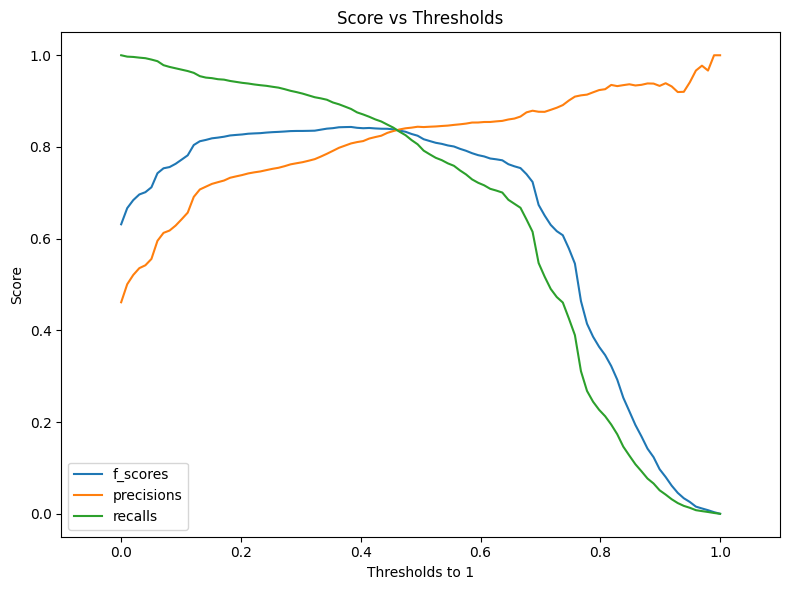

In [94]:
f_scores = []
precisions = []
recalls = []
thresholds = np.linspace(0, 1, 100)
for threshold in thresholds:
    pred = distribution[:,1] > threshold
    f_score, precision, recall = confusion_matrix(pred, y_test, verbose=False, plot=False)
    f_scores += [f_score]
    precisions += [precision]
    recalls += [recall]
    
plt.figure(figsize=(8,6))

plt.plot(thresholds, f_scores, marker="", label="f_scores")
plt.plot(thresholds, precisions, marker="", label="precisions")
plt.plot(thresholds, recalls, marker="", label="recalls")

plt.xlabel('Thresholds to 1')
plt.ylabel('Score')
plt.title(f'Score vs Thresholds')
# plt.ylim(0.9, 1.0)
plt.xlim(thresholds[0] - 0.1, thresholds[-1] + .1)
plt.tight_layout()
plt.legend()


### D) Plot in a bar chart the coefficients of the logistic regression sorted by their contribution to the prediction.

In [103]:
# model.coef_[0]
tmp = []
for name, value in zip(X_train.columns, model.coef_[0]):
    tmp.append({"name": name, "value": value})
    
features_coef = pd.DataFrame(tmp).sort_values("value")
features_coef.head()

,name,value
23,sex_upon_outcome_Intact Male,-1.733549
26,sex_upon_outcome_Unknown,-1.225974
22,sex_upon_intake_Unknown,-1.225974
16,intake_type_Public Assist,-1.103293
21,sex_upon_intake_Spayed Female,-0.873469


<BarContainer object of 27 artists>

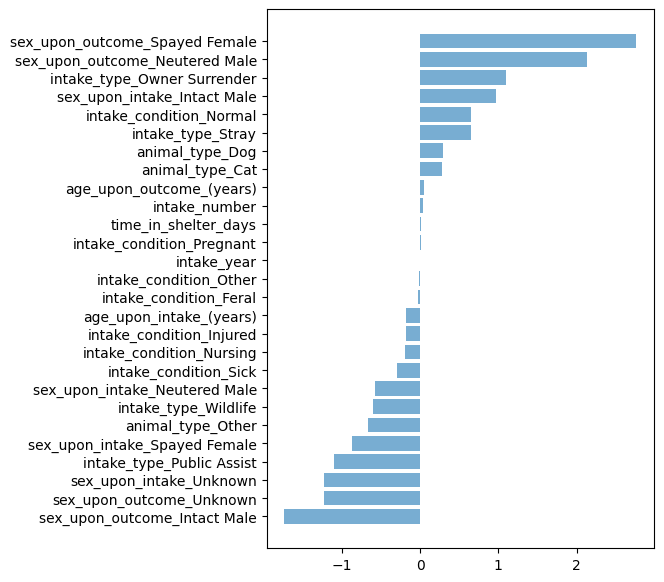

In [104]:
plt.subplots(figsize=(5,7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)


## Question 1: Which of the following metrics is most suitable when you are dealing with unbalanced classes?

- a) F1 Score
- b) Recall
- c) Precision
- d) Accuracy

In [108]:
"A"

'A'

## Question 2: You are working on a binary classification problem. You trained a model on a training dataset and got the following confusion matrix on the test dataset. What is true about the evaluation metrics (rounded to the second decimal point):

|            | Pred = NO|Pred=YES|
|------------|----------|--------|
| Actual NO  |    50    |   10   |
| Actual YES |    5     |   100  |

- a) Accuracy is 0.95
- b) Accuracy is 0.85
- c) False positive rate is 0.95
- d) True positive rate is 0.95

In [105]:
(100 + 50) / (100 + 50 + 5 + 10)

0.9090909090909091

In [106]:
(100) / (105)

0.9523809523809523

In [107]:
"D"

'D'